## Supervised machine learning

Having explored some unsupervised machine learning methods yesterday, we will move on to supervised techniques. Supervised learning is the task of finding a mapping from input data to output labels based on example input-output pairs. During the training (or fitting) phase, the model builds an internal function which maps input to output, ideally in a way that can be generalized to unseen data successfully. Once a model is trained, it can be used to predict output labels from the input data alone.

They come in two main groups: classifiers for categorical labels, and regressors for continuous numeric labels.

Our first dataset will be the mice gene expression data on the input side, and the categorical diet labels on the output (or target) side. The first supervised model that we will train and evaluate will be a support vector classifier.

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [10]:
xls = pd.read_excel('../files_day_five/aad0189_DataFileS5.xlsx', header=2)
expr = xls.groupby('Gene.1').mean()  # or 'Gene' if you had used that for your DE calculations
expr = expr.loc[:, expr.columns.str.contains('Liver')]
is_hfd = pd.Series(expr.columns.str.contains('HFD'), index=expr.columns)  # diet labels for verification

data = expr.T    # let's use the name 'data' for input
target = 1*is_hfd  # let's use the name 'target' for the labels / expected outputs. For simplicity, use 1/0 instead of True/False

## Task 1: Create a support vector classifier using a linear kernel

### 1.1 Train it with the whole dataset

In [13]:
clf = LinearSVC(random_state=0)
clf.fit(data, target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

### 1.2 Evaluate its accuracy on the training data
We are asking you to commit a **mortal sin**: evaluate a machine learning algorithm on the same data that you had trained it with. But do it anyway. Are you surprised by its accuracy?

In [18]:
# Not surprised because it has seen all of the before so it should have an accuracy of 100%
print('ACCURACY:', clf.score(data, target, sample_weight=None))

ACCURACY: 1.0


### 1.3 Compare the support vector with the 4 component vectors from yesterday's PCA
To save you the trouble of moving code between sheets, we provided you the PCA code below.

Find a suitable way of comparing them, and discuss what you found.

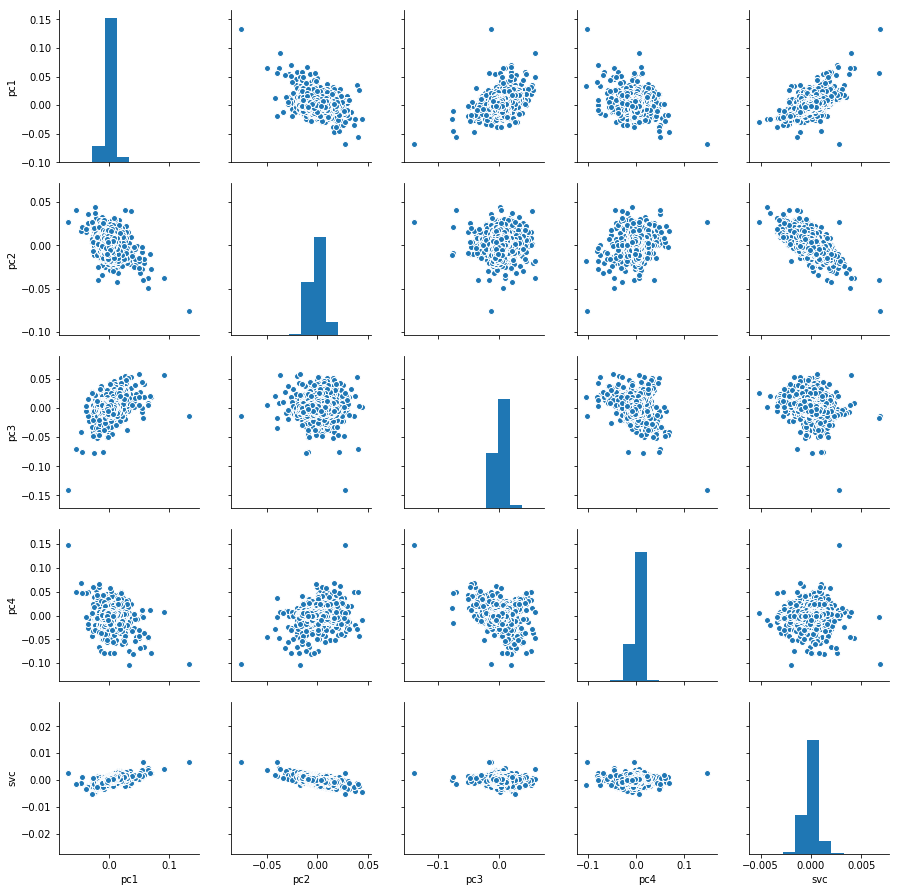

In [25]:
pca = PCA(n_components=4)
pca.fit(data)
coeffs = pd.DataFrame(pca.components_, index=['pc1', 'pc2', 'pc3', 'pc4']).T
coeffs['svc'] = clf.coef_.T

sns.pairplot(coeffs)


### 1.4 Validate the model in a legitimate way
In 1.2 we asked you to evaluate the model with the same data you had trained it with. It's a poor and frowned upon way to test a model's accuracy, since you can't tell whether the model has merely memorized the exact inputs and expected outputs, or whether it truly found generalizable patterns in the data. The former scenario is often called *overfitting*.

This time, train the model with one half of the data, and validate its accuracy on the other half. Keep it simple for now, rows `::2` for training and `1::2` for validating should be good enough.

In [27]:
clf.fit(data[::2], target[::2])
# Not surprised because it has seen all of the before so it should have an accuracy of 100%
print('ACCURACY:', clf.score(data[1::2], target[1::2], sample_weight=None))

ACCURACY: 1.0


### 1.4.2 Reduce the number of features
You may have found that the model still performs excellent, and it was successful at learning the structure of the data instead of just memorizing the training data. This a good sign, and it seems that it's no challenge for an SVM to distinguish the two diets from the full expression dataset. Let's make the SVM sweat a bit.

Try cutting down the number of used features until the point that validation is no longer fully accurate. Keep only every N-th feature (e.g. train and validate with data.iloc[::2,::N] and data.iloc[1::2, ::N]) until the model starts making mistakes. You can simply re-run the same jupyter cell with increasing N-s: we don't expect a graph or exhaustive measurements here, just find one big enough N that the accuracy isn't perfect anymore.

In [72]:
# Starting from N = ~30 it starts to not be perfect anymore on the other hand even with N = 1000 you get a 
# an accuracy of 85% which is quite good
# Funny to see that at N = 15000 for example it still has an accuracy of 70% which shows 
# that a good feature is hit at that index
clf.fit(data.iloc[::2, ::1500], target.iloc[::2])
# Not surprised because it has seen all of the before so it should have an accuracy of 100%
print('ACCURACY:', clf.score(data.iloc[1::2, ::1500], target.iloc[1::2], sample_weight=None))

# Be careful with high dimensional data while having a small amount of features -> curse if high dimensionality

ACCURACY: 0.975


### 1.5 Perform cross-validation
Previously you had separated your data into a disjoint training and testing set, trained the model with the training set and computed its accuracy on the testing set. But couldn't you switch them around, do it the other way, and compute a second accuracy value? The average of those two values would give you an even better estimate of the real accuracy. Indeed you could, and it would be called *2-fold cross-validation*.

3-fold cross-validation is when you split your data to D1/D2/D3 thirds, train the model with D1+D2 and test on D3. Then train with D1+D3 and test on D2, finally train with D2+D3 and test on D1. The average of the three accuracy values would be your model's 3-fold cross-validated accuracy.

(Sidenote: the *model* is the linear SVM with whatever default parameters it has, plus the features that you selected. During cross-validation you test different *instances* of the same model: you train them with different data so they will all end up slightly different, you test them with different data so the accuracy estimates will also be different, but you are validating the same *model* all along.)

`sklearn` gives you helper classes to split your data into training and testing sets following a cross-validation scheme, saving you most of the legwork. Some classes even support features like random shuffling, or stratification (keeping labels balanced across training/testing classes). Choose a simple one, and cross-validate your model on the restricted amount of features chosen in 1.4.2.

In [118]:
data2 = data.iloc[:, ::1800]

# Split data
X_train, X_test, y_train, y_test = train_test_split(data2, target, test_size=0.3, random_state=0)

# Use splits for training and testing 
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test) 

# Do cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True)
# for train, test in kf.split(data2, target):
#     data_train = data2.iloc[train]
#     data_test = data2.iloc[test]
#     target_train = target.iloc[train]
#     target_test = target.iloc[test]
#     clf.fit(data_train, target_train)
#     print(clf.score(data_test, target_test))

# Does all the steps which are commented out
cross_val_score(clf, data2, target, cv=kf)

array([0.76470588, 0.75      , 0.8125    , 0.8125    , 0.9375    ])